The data is annotated for named entities:
1. Person
2. Location
3. Group
4. Creative work
5. Corporation
6. Product

Possible approaches include, rule based model, training Sequence to sequence model from scratch or use transformers.

Rule based approcahes are not used here as it is exhaustive and maynot always converge to a generalization.
The approach used in this experiment is to train a sequence to sequence model using LSTM.As per the size of the data and distributation of classes across the data, this approach promises to be fruitful. Due to lack of computational resources in the local machine, this notebook donot useses any Transformer based approaches. 

In [2]:
import numpy as np
import spacy
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Activation, TimeDistributed
from tensorflow.keras.models import Sequential
import gensim
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

def recall_m(y_true, y_pred):
  '''This function can be used while compiling any sequential or functional model
  to include the recall value as one of the metric
  Inputs:
        y_true : tensor object
        y_pred : tensor object
  Returns:
        calculated recall value
  '''
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
  possible_positives = K.sum (K.round(K.clip(y_true, 0, 1)))
  recall = true_positives/(possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  '''This function can be used while compiling any sequential or functional model
  to include the precision value as one of the metric
  Inputs:
        y_true : tensor object
        y_pred : tensor object
  Returns:
        calculated precision value
  '''
  true_positives = K.sum(K.round(K.clip (y_true* y_pred, 0, 1)))
  predicted_positives = K.sum (K. round (K.clip (y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision


def f1_m(y_true, y_pred):
  '''This function can be used while compiling any sequential or functional model
  to include the f1 score value as one of the metric
  Inputs:
        y_true : tensor object
        y_pred : tensor object
  Returns:
        calculated f1 score value
  '''
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

def plot_graphs(history, string):
  '''This function is used to plot traing history of any one metric
  Inputs:
        history : model object
        string  : metric name as string 
  Returns:
        calculated precision value'''
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel (string)
  plt.show()

def preprocess_data(data,balance_data=False,balance_fraction = 0.0):
  '''The function preprocess the raw data , add necessary features and generate
  preprocessed data frames
  Input :
         data : Dataframe 
         balance_data : boolean flag to remove maajority  samples
         balance_fraction : float type, fraction  of data to be removed'''
  for index in data[data.word.isnull()].index:
    data.iloc[index].whole_tag = 'END'

  data['word'] = data.apply(lambda row: row['word'] if row['whole_tag'] != 'END' else "",axis = 1)
  data['IOB'] = data.whole_tag.apply(lambda x:x if x == 'END' else x[0])
  data['tag'] = data.whole_tag.apply(lambda x:'O' if len(x) == 1 or x == 'END' else x[2:])

  data.reset_index(drop = True, inplace=True)
  data['sentence_idx'] = None
  init= 0
  for idx in data.index[1:]:
    if data.iloc[idx].whole_tag == 'END':
      data.loc[idx].sentence_idx = init
      init += 1
      #print(init,idx,data.iloc[idx].whole_tag)
  data.loc[idx].sentence_idx = init
  data['sentence_idx'] = data.sentence_idx.bfill()
  data['tag'] = data['tag'].astype('category')
  data['tag_encoded'] = data['tag'].cat.codes

  words = pd.DataFrame(data.groupby('sentence_idx')[ 'word'].apply(list))
  tags = data.groupby('sentence_idx')['tag_encoded'].apply(list)
  words['tag'] = tags
  if balance_data:
    print("Removing majority samples...")
    words ['all_0'] = words.tag.apply(lambda x: True if len(set (x)) == 1 else False)
    words = words.drop(words [words ['all_0'] == True].sample (frac=balance_fraction). index)
    words.drop(columns = ['all_0'], inplace = True)
  return words, data


In [5]:
test_path = "/content/drive/MyDrive/NER/test.txt"
train_path = "/content/drive/MyDrive/NER/train.txt"

raw_data_train =  pd.read_csv(train_path, sep='\t', header=None, names=['word', 'whole_tag']) #reading raw train data

#Read the label less test data seperatly (As the file had certain unresolvable issues, it cvould not be read directily)
with open(test_path, "r", encoding='utf-8') as file:
  lines = [line.rstrip() for line in file]
  raw_data_test = pd.DataFrame()
  raw_data_test['word'] = lines
  raw_data_test['sentence_idx'] = None

#prepare the raw test data for testing
init= 0
for idx in raw_data_test.index[1:]:
  if len (raw_data_test.iloc[idx].word) == 0:
    raw_data_test.loc[idx].sentence_idx = init
    init += 1

raw_data_test. sentence_idx = raw_data_test.sentence_idx.bfill()
data_test=pd.DataFrame(raw_data_test.groupby('sentence_idx')['word'].apply(list))

#prepare the train data for training
balance_data=True       #setting the balancing parameter to true to remove majority samples
balance_fraction = 0.4  #fraction of majority samples to be removed

data_train, processed_data = preprocess_data(raw_data_train,balance_data, balance_fraction = 0.4)

Removing majority samples...


In [28]:
raw_data_train

,word,whole_tag,IOB,tag,sentence_idx,tag_encoded
0,@paulwalk,O,O,O,0,0
1,It,O,O,O,0,0
2,'s,O,O,O,0,0
3,the,O,O,O,0,0
4,view,O,O,O,0,0
...,...,...,...,...,...,...
57888,39,O,O,O,2168,0
57889,GMT+0000,O,O,O,2168,0
57890,(,O,O,O,2168,0
57891,UTC,O,O,O,2168,0


# **EDA**

Through EDA it was found that there are lot many samples with tag "O"' which can be removed to improve the model performance from overfitting. It also aided to find the max length of words to be used for padding.

class distribution : 
O                55165
person             854
location           720
group              362
product            293
creative-work      260
corporation        239
Name: tag, dtype: int64

Total words : 57893 
Total unique words :13795
Total sentences: 1601
Unique named entities to detect ['location', 'group', 'corporation', 'person', 'creative-work', 'product']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


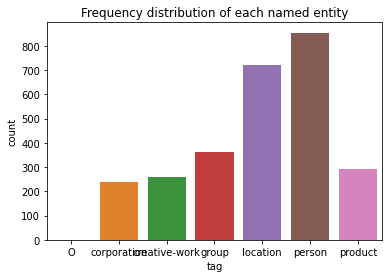

Text(0.5, 1.0, 'Frequency distribution of number of word counts')

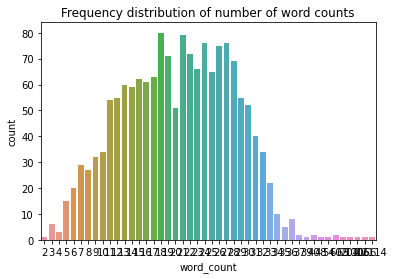

In [14]:
print(f"class distribution : \n{processed_data.tag.value_counts()}")
temp = processed_data[processed_data.tag!= 'O']
print (f"\nTotal words : {processed_data.shape [0]} \nTotal unique words :{len(set (processed_data.word))}")
print (f"Total sentences: {data_train. shape[0]}")
print(f"Unique named entities to detect {list(temp.tag.unique())}")
seaborn.countplot(temp.tag).set_title("Frequency distribution of each named entity")
#plt.set_title("LaLaLa")
plt.show()
data_train['word_count'] = data_train.tag.apply(lambda x: len(x))
seaborn.countplot(data_train.word_count).set_title("Frequency distribution of number of word counts")

In [15]:
data_train

,word,tag,word_count
sentence_idx,,,
0,"[@paulwalk, It, 's, the, view, from, where, I,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, ...",28
1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",16
2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13
3,"[today, is, my, last, day, at, the, office, ., ]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10
4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13
...,...,...,...
2162,"[STOP, WHAT, YOU'RE, DOING, AND, GO, GET, #Exp...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12114
2164,"[http://t.co/jplCS8RDDs, January, 04, ,, 2015,...","[0, 0, 0, 0, 0, 0, 0, 0, 0]",9
2166,"[[, li, ..., @null, Senin, ,, 05, January, 201...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1006


In [80]:
processed_data

,word,whole_tag,IOB,tag,sentence_idx,tag_encoded
0,@paulwalk,O,O,O,0,0
1,It,O,O,O,0,0
2,'s,O,O,O,0,0
3,the,O,O,O,0,0
4,view,O,O,O,0,0
...,...,...,...,...,...,...
57888,39,O,O,O,2168,0
57889,GMT+0000,O,O,O,2168,0
57890,(,O,O,O,2168,0
57891,UTC,O,O,O,2168,0


In [17]:
#prepare the test and train data for training

all_tags_train = data_train['tag']      #all training tags
all_token_train = data_train ['word']   #all training sentences
all_token_test= data_test['word']       #all testing sentences
#MAX_LEN=max(map (len, all_token_train))
MAX_LEN = 65                            #taking max_len as 65 as per EDA insted of sentence length
tokenizer = Tokenizer (oov_token= "<00V>")
tokenizer.fit_on_texts (all_token_train)
word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences (all_token_train)  #tokenize and encode the train data
sequences_test = tokenizer.texts_to_sequences (all_token_test)    #tokenize and encode the test data
#create X_train and y_train
X_train = pad_sequences(sequences_train, padding= 'post',maxlen = MAX_LEN)  #pad the train data to max length
y_train = pad_sequences(all_tags_train, padding = 'post',maxlen = MAX_LEN)  #pad the train labels to max length
y_train = to_categorical(y_train)                                           #changing the traain labels to categorical values
#create X_test
X_test=pad_sequences (sequences_test, padding = 'post',maxlen = MAX_LEN)    #pad the test data to max length

In [19]:
#Seperatily training the embedding model, to extract weights to be used in embedding layer in the LSTM sequence model.
EMBED_DIM = 300
n_units = 64
num_words = len(word_index) + 1    #total number of words in the vocabulary
#creating word embedding model
w2vmodel = gensim.models.Word2Vec (size = EMBED_DIM, window = 5, min_count = 1, workers = 16)
w2vmodel.build_vocab(all_token_train)

training_examples_count = w2vmodel.corpus_count
w2vmodel.train (all_token_train, total_examples = training_examples_count,epochs=100)
embedding_matrix = np.zeros((num_words, EMBED_DIM))
#extractingembedding matrix
for word, index in word_index.items():
  if word in w2vmodel.wv:
    embedding_matrix[index] = w2vmodel.wv[word]

In [20]:
#creating LSTM model for Sequence to sequence modelling
embedding = Embedding(num_words, EMBED_DIM, weights = [embedding_matrix], input_length = MAX_LEN, trainable=False)
model = Sequential()
model.add(embedding)
model.add(Bidirectional(LSTM(n_units,activation = "tanh",return_sequences = True,recurrent_activation = 'sigmoid')))
model.add(TimeDistributed(Dense(7,activation = 'sigmoid')))

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',
              metrics=['accuracy',precision_m, recall_m,f1_m])
history =  model.fit(X_train, y_train, batch_size = 64, epochs = 25, verbose = 1, shuffle = True)


Epoch 1/25
26/26 [==============================] - 7s 14ms/step - loss: 1.1880 - accuracy: 0.9437 - precision_m: 0.8858 - recall_m: 0.9629 - f1_m: 0.9127
Epoch 2/25
26/26 [==============================] - 0s 9ms/step - loss: 0.1778 - accuracy: 0.9818 - precision_m: 0.9825 - recall_m: 0.9825 - f1_m: 0.9825
Epoch 3/25
26/26 [==============================] - 0s 8ms/step - loss: 0.1303 - accuracy: 0.9818 - precision_m: 0.9807 - recall_m: 0.9807 - f1_m: 0.9807
Epoch 4/25
26/26 [==============================] - 0s 8ms/step - loss: 0.1212 - accuracy: 0.9818 - precision_m: 0.9825 - recall_m: 0.9825 - f1_m: 0.9825
Epoch 5/25
26/26 [==============================] - 0s 8ms/step - loss: 0.1135 - accuracy: 0.9818 - precision_m: 0.9807 - recall_m: 0.9807 - f1_m: 0.9807
Epoch 6/25
26/26 [==============================] - 0s 8ms/step - loss: 0.1066 - accuracy: 0.9818 - precision_m: 0.9766 - recall_m: 0.9766 - f1_m: 0.9766
Epoch 7/25
26/26 [==============================] - 0s 8ms/step - loss: 0.1

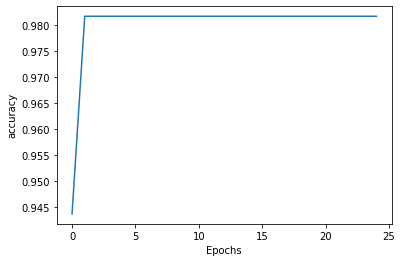

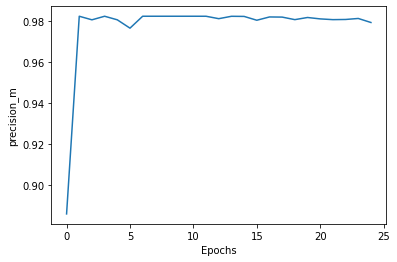

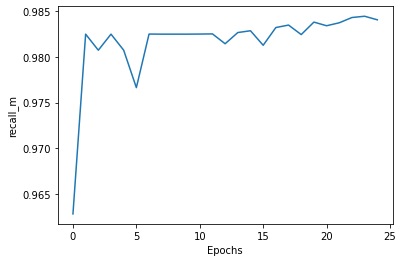

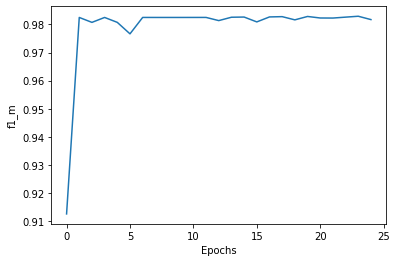

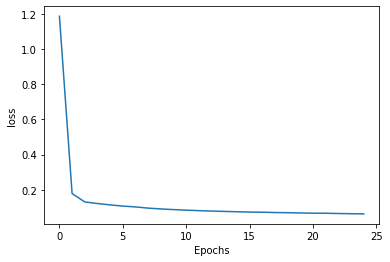

41/41 [==============================] - 1s 6ms/step


In [21]:
plot_graphs(history, "accuracy")
plot_graphs(history, "precision_m")
plot_graphs(history, "recall_m")
plot_graphs(history, "f1_m")
plot_graphs(history, "loss")
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis = -1)


In [22]:
#confidence score
confidence_score = np.zeros((y_pred_class.shape))
for sample in range (y_pred_class.shape [0]):
  for idx in range (y_pred_class.shape [1]):
    ent = y_pred_class [sample, idx]
    score=y_pred [sample, idx, ent]
    confidence_score[sample, idx] = score

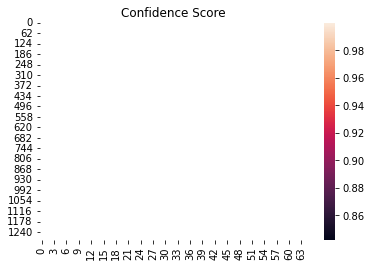

In [26]:
ax = seaborn.heatmap(confidence_score, linewidth=0.5).set_title("Confidence Score")
plt.show()